In [ ]:
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab10')
from sklearn import datasets
import torch
device = torch.device('cpu')
from copy import deepcopy
from sbi.neural_nets.flow import build_nsf

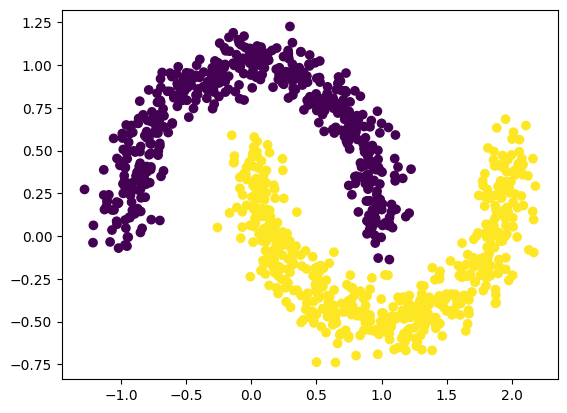

In [3]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

In [10]:
y.shape

torch.Size([128, 1])

In [8]:
flow = build_nsf(
    batch_x=torch.Tensor(x),
    batch_y=torch.Tensor(y[:, None]),
    z_score_x=None, #'independent',
    z_score_y=None, #'independent',
    hidden_features=100,
    num_transforms=10,
    num_bins=10,
    # embedding_net: nn.Module = nn.Identity(),
    tail_bound=1.,
    # hidden_layers_spline_context: int = 1,
    num_blocks=5,
    dropout_probability=0.,
    use_batch_norm=False,
    )

In [9]:
epochs = 1000
batch_size = 128
lr = 1e-3

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
best_epoch = 0
best_loss = np.inf

for epoch in range(epochs):    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.Tensor(x).to(device)
    y = torch.Tensor(y[:, None]).to(device)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if loss < best_loss:
        best_epoch = epoch
        best_loss = loss
        best_flow = deepcopy(flow)
        
    print(epoch, float(loss))

ValueError: Expected features = 1, got 2.

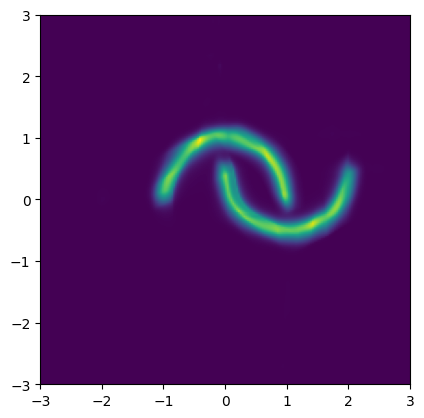

In [6]:
p = 3
n = 200

x = np.linspace(-p, p, n)
y = np.linspace(-p, p, n)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.concatenate(
    [xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)],
    axis=1,
    dtype=np.float32,
    )

with torch.no_grad():
    zgrid = torch.zeros(xy.shape[0])
    for context in [0., 1.]:
        zgrid += best_flow.log_prob(
            torch.tensor(xy), torch.tensor([[context]]*xy.shape[0]),
            ).exp()#.reshape(n, n)
        
plt.imshow(
    zgrid.numpy().reshape(n, n),
    origin='lower',
    aspect='equal',
    extent=(-p, p, -p, p),
    );